In [1]:
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import os
import time

# Dyskryminator

In [2]:
def disc_block(channels):
    conv = tf.keras.layers.Conv2D(filters=channels, kernel_size=(4,4), padding='same', strides=2)
    batch_norm = tf.keras.layers.BatchNormalization()
    leaky_relu = tf.keras.layers.LeakyReLU(0.2)

    return [conv, batch_norm, leaky_relu]


In [3]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64,64,3))]+
    disc_block(64)+
    disc_block(128)+
    disc_block(128)+[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-10 12:20:47.203383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 12:20:47.203499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

Tworzę model dyskryminatora jako keras.Sequential, ponieważ chcemy by wszystkie warstwy były wykonane po kolei.  
Warstwy ustawiam tak jak w poleceniu, przy pomocy warstw z tf.keras.layers: Input, Flatten, Dropout, Dense, oraz bloków, które zwracają listy Conv2D, BatchNormalization, LeakyReLu.

# Generator

In [24]:
def gen_block(channels):
    conv = tf.keras.layers.Conv2DTranspose(filters=channels,kernel_size=(4,4),strides=2,padding='same')
    leaky_relu = tf.keras.layers.LeakyReLU(0.2)

    return [conv, leaky_relu]


In [25]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*8*8, input_shape=(128,)),
    tf.keras.layers.Reshape((8,8,128))]+
    gen_block(128)+
    gen_block(256)+
    gen_block(512)+[
    tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5),strides=1,padding='same',activation='sigmoid')
])

In [26]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)      

Tworzę model generatora jako keras.Sequential, ponieważ chcemy by wszystkie warstwy były wykonane po kolei.  
Warstwy ustawiam tak jak w poleceniu, przy pomocy warstw z tf.keras.layers: Input, Dense, Reshape, Conv2D oraz bloków, które zwracają listy Conv2DTranspose, LeakyReLu.

In [8]:
tmp1 = tf.random.normal(shape=(1,128), mean=0, stddev=1)

In [9]:
tmpimg = generator.predict(tmp1)

1/1 [==============================] - 0s 113ms/step


2022-11-09 22:29:39.023079: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-09 22:29:39.081701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [5]:
def print_image(img, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

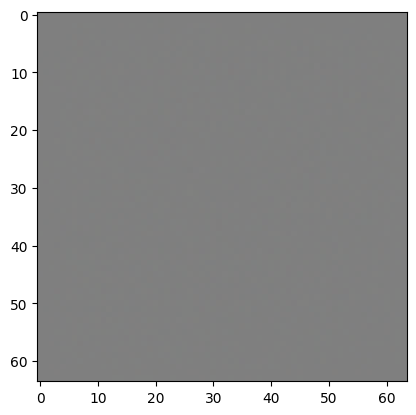

In [43]:
print_image(tmpimg[0])

Bardzo dziwne, spodziewałem się szumu, a nie wszędzie szarości, ale może taki jest efekt tego szumu...

# Dataset

Próbowałem poszukać innych zdjęć, ale zawsze miałem problemy, żeby zdjęcia były w miarę podobne, ale miały również dosyć charakterystyczne cechy(próbowałem oczy, galaktyki, sushi - może za bardzo przejąłem się by nie były zbyt różnorodne...).  
Dlatego zdecydowałem się również na ciasto marchewkowe. 

In [6]:
root = Path().cwd()/"cake"
if not os.path.isdir(root):
    duckduckgo_search(root, 'cake', 'carrot cake', 700)
display_image_cleaner(root)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [7]:
seed = 666

def normali(image):
    return image/255.

def load_ds(root=root, image_size=(64,64)):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        root, label_mode=None, batch_size=8, image_size=image_size,
        seed=seed)
    return ds.map(normali)

ds = load_ds()

Found 400 files belonging to 1 classes.


2022-11-10 12:20:54.830438: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


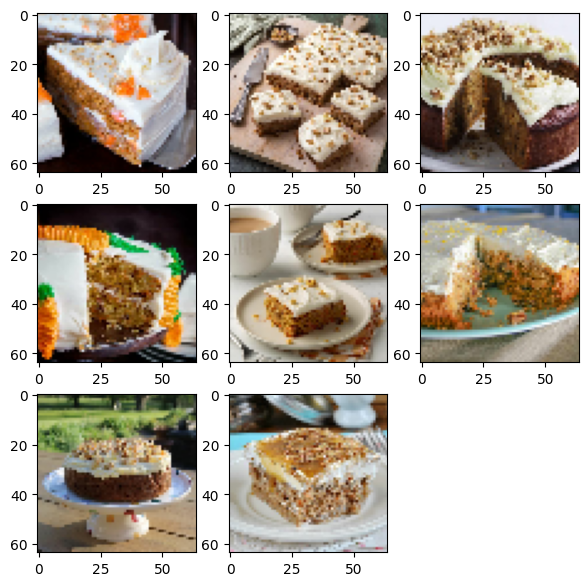

In [8]:
plt.figure(figsize=(7, 7))
for image in ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
  plt.show()

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.1),
    tf.keras.layers.RandomZoom(0.1)
])

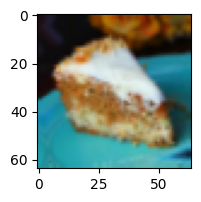

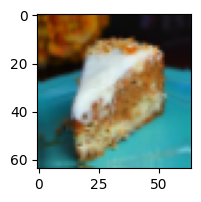

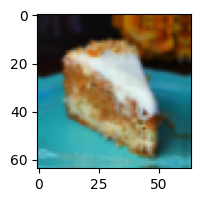

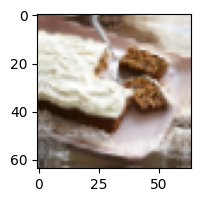

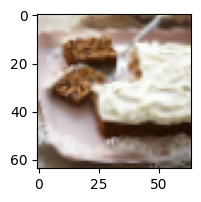

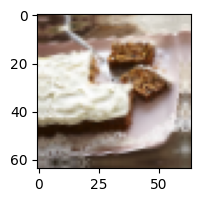

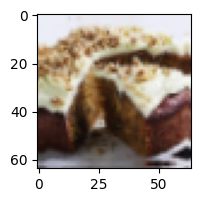

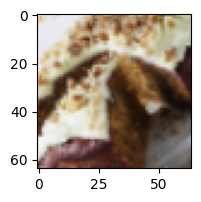

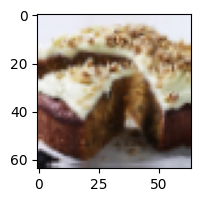

In [10]:
for batch in ds.take(1):
    for i in range(3):
        plt.figure(figsize=(2,2))
        plt.imshow(data_augmentation(batch[i], training=True))
        plt.show()
        plt.figure(figsize=(2,2))
        plt.imshow(data_augmentation(batch[i], training=True))
        plt.show()
        plt.figure(figsize=(2,2))
        plt.imshow(data_augmentation(batch[i], training=True))
        plt.show()


Wydaje się działa, ale musiałem ustawić Training na true.  
Stworzyłem model do augmentacji danych, bardzo podobnie do zwykłego modelu, korzystając z keras.Sequential, lecz zamiast normalnych warstw użyłem: RandomFlip, RandomRotation, RandomZoom

# Uczenie

### Test

In [16]:
tmp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(2)
])
tmp = tf.random.normal((5,3))


In [17]:
tmp_model(tmp)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.7794367 , -0.40827325],
       [-0.85448563,  0.67164075],
       [-0.2704121 ,  0.5809953 ],
       [ 0.40158522,  0.2539319 ],
       [ 0.6180287 , -0.97065103]], dtype=float32)>

In [18]:
print(tmp_model.layers[0].trainable_weights)
print(tmp_model.layers[1].trainable_weights)

[<tf.Variable 'dense_2/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.12693548, -0.27203465,  0.00496244],
       [-0.84573627,  0.84611654, -0.4908874 ],
       [ 0.53634214, -0.31878066, -0.9396374 ]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
[<tf.Variable 'dense_3/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.2783603 ,  1.0072887 ],
       [ 0.00788045,  0.25725663],
       [ 0.13284278,  0.6137775 ]], dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]


In [20]:
print(tmp_model.layers[0].trainable_weights)
print(tmp_model.layers[1].trainable_weights)

[<tf.Variable 'dense_2/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-2.737655  , -0.5221699 , -0.08830219],
       [ 3.1534595 ,  2.81526   , -0.23918754],
       [ 1.6967098 ,  0.06172218, -0.4356367 ]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(3,) dtype=float32, numpy=array([ 7.363396 ,  5.262966 , -0.3055476], dtype=float32)>]
[<tf.Variable 'dense_3/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.47335184,  0.11571991],
       [-0.23483163,  0.6558689 ],
       [ 0.3540933 , -0.37853712]], dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]


Te dwie cellki powyżej, były uruchomione w takiej kolejności by się upewnić, że tylko pierwsza warstwa się zmieniła podczas uczenia.  
To znaczy, że najpierw uruchomiłem pierwszą cellkę, później uczenie a na sam koniec drugą cellkę.

In [18]:
def tmp_loss(exp, pred):
    return exp-tf.math.reduce_mean(pred, axis=1)

tmp_loss(42, tmp_model(tmp))

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([41.81442 , 42.091423, 41.844707, 41.67224 , 42.17631 ],
      dtype=float32)>

In [19]:
tmp_opt = tf.keras.optimizers.SGD(learning_rate=0.5)

print(tf.reduce_mean(tmp_loss(42, tmp_model(tmp))))
for _ in range(10):
    with tf.GradientTape() as tape:
        preds = tmp_model(tmp)
        loss_tmp = tmp_loss(42, preds)
        print(tf.reduce_mean(loss_tmp))
    tmp_grads = tape.gradient(loss_tmp, tmp_model.layers[0].trainable_weights)
    tmp_opt.apply_gradients(zip(tmp_grads, tmp_model.layers[0].trainable_weights))

print(tf.reduce_mean(loss_tmp))

tf.Tensor(41.91982, shape=(), dtype=float32)
tf.Tensor(41.91982, shape=(), dtype=float32)
tf.Tensor(41.504265, shape=(), dtype=float32)
tf.Tensor(41.088707, shape=(), dtype=float32)
tf.Tensor(40.673153, shape=(), dtype=float32)
tf.Tensor(40.257595, shape=(), dtype=float32)
tf.Tensor(39.842037, shape=(), dtype=float32)
tf.Tensor(39.426483, shape=(), dtype=float32)
tf.Tensor(39.010925, shape=(), dtype=float32)
tf.Tensor(38.595367, shape=(), dtype=float32)
tf.Tensor(38.17981, shape=(), dtype=float32)
tf.Tensor(38.17981, shape=(), dtype=float32)


Wygląda na to, że działa.  
Stworzyłem funkcję loss oraz pętlę uczenia, która wykorzystuje GradientTape do wyliczenia gradientu, po wymienionych parametrach oraz apply_gradients po wymienionych parametrach.

### Real

#### Dyskryminator

In [11]:
disc_loss_metric = tf.keras.metrics.Mean()
gen_loss_metric = tf.keras.metrics.Mean()

In [12]:
for tmp in ds:
    tmp_batch = tmp
    break

In [18]:
def prep_data(batch):
    # aug_imgs = [data_augmentation(img, training=True) for img in batch for batch in ds.take(1)]
    # aug_imgs = [data_augmentation(img, training=True) for img in batch]
    aug_imgs = data_augmentation(batch, training=True)
    # aug_imgs = batch
    gen_imgs = generator(tf.random.normal(shape=(8,128), mean=0, stddev=1), training=True)
    label_changes = tf.concat([-tf.math.abs(tf.random.normal((8,1),stddev=0.05)), tf.math.abs(tf.random.normal((8,1),stddev=0.05))], axis=0)
    labels = tf.concat([tf.ones((8,1)),tf.zeros((8,1))], axis=0) + label_changes
    imgs = tf.concat([aug_imgs,gen_imgs],axis=0)
    return imgs,labels

tf.reduce_all(prep_data(tmp_batch)[0]==prep_data(tmp_batch)[0]) # Images are different each time

2022-11-10 12:21:51.479719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-10 12:21:51.925714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-10 12:21:52.576285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-10 12:21:53.086901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [21]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [20]:
def discriminator_step(batch):
    with tf.GradientTape() as tape:
        imgs,labels=prep_data(batch)
        preds = discriminator(imgs)
        loss = loss_fn(labels, preds)
    # print('Discriminator loss:',loss)
    gradients = tape.gradient(loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))
    # if disc_loss_metric:
    disc_loss_metric.update_state(loss)

discriminator_step(tmp_batch)
disc_loss_metric.reset_states()

2022-11-10 12:21:53.701917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-10 12:21:54.164852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Upewniam się, że labels są w zakresie [0,1]. oraz są zmienone o +-0.05.  
Korzystam z optimizers.Adam z learning rate podanym w treści zadania, oraz funkcji losses.BinaryCrossentropy().  
Dodatkowo podobnie jak wcześniej, upewniam się że tylko dyskryminator ma poprawiane wagi, dzięki GradientTape, GradientTape().gradient i optimizers.Adam().apply_gradients.  
Niestety nie umiem sobie poradzić z retracingiem - nie wiem z czego tutaj wynika... (Może być związane z "WARNING:tensorflow:Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.", którego też nietety nie umiem rozwiązać... - jeśli wyciągnę augmentację przed uczenie, to działa znacznie lepiej, ale augmentacja jest gorsza...)

#### Generator

In [22]:
def gen_batch():
    return generator(tf.random.normal(shape=(8,128), mean=0, stddev=1)), tf.ones(8)


In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [24]:
def generator_step():
    with tf.GradientTape() as tape:
        imgs,labels = gen_batch()
        preds = discriminator(imgs)
        loss = loss_fn(labels, preds)
    # print('Generator loss:', loss)
    gradients = tape.gradient(loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_weights))
    # if gen_loss_metric:
    gen_loss_metric.update_state(loss)

generator_step()
gen_loss_metric.reset_states()


Korzystam z optimizers.Adam z learning rate podanym w treści zadania, oraz funkcji losses.BinaryCrossentropy().  
Dodatkowo podobnie jak wcześniej, upewniam się że tylko generator ma poprawiane wagi, dzięki GradientTape, GradientTape().gradient i optimizers.Adam().apply_gradients.


#### Checkpoints

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# checkpoint.restore(checkpoint_prefix+'-71')

In [25]:
@tf.function(reduce_retracing=True)
def train_step(batch):
    discriminator_step(batch)
    generator_step()


In [26]:
def print_images(imgs, epoch=None):
    plt.figure(figsize=(7, 7))
    for ix,img in enumerate(imgs):
        ax = plt.subplot(3, 3, ix + 1)
        plt.imshow(img)
    if epoch:
        plt.savefig(f'./cmpimages/cmpnew{epoch}.png')
    # else:
    plt.show()


# print_images(generator(tf.random.normal(shape=(9,128), mean=0, stddev=1)), 1)

In [27]:
tf.get_logger().setLevel('ERROR')

In [28]:
def train(ds=ds, last_checkpoint=0, epochs=200):
    cmp = tf.random.normal(shape=(9,128), mean=0, stddev=1)
    for epoch in range(last_checkpoint, last_checkpoint+epochs):
        start = time.time()
        for batch in ds:
            train_step(batch)
        if (epoch+1)%50 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)#+str(epoch))
            print(epoch)
            print_images(generator(cmp), epoch=epoch)
            print(f'Time for epoch {epoch + 1} is {time.time()-start} sec\t\tdisc loss: {disc_loss_metric.result()} \t gen loss: {gen_loss_metric.result()}')
        else:
            print(f'Time for epoch {epoch + 1} is {time.time()-start} sec\t\tdisc loss: {disc_loss_metric.result()} \t gen loss: {gen_loss_metric.result()}', end='\r')
        disc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

# train(last_checkpoint=1599, epochs=205)

# train(last_checkpoint=1199+205, epochs=205)
# train(last_checkpoint=599+205+205, epochs=3000-(599+205+205)+1)

1849 for epoch 1849 is 7.870222091674805 sec		disc loss: 0.6847546100616455 	 gen loss: 0.70808315277099611


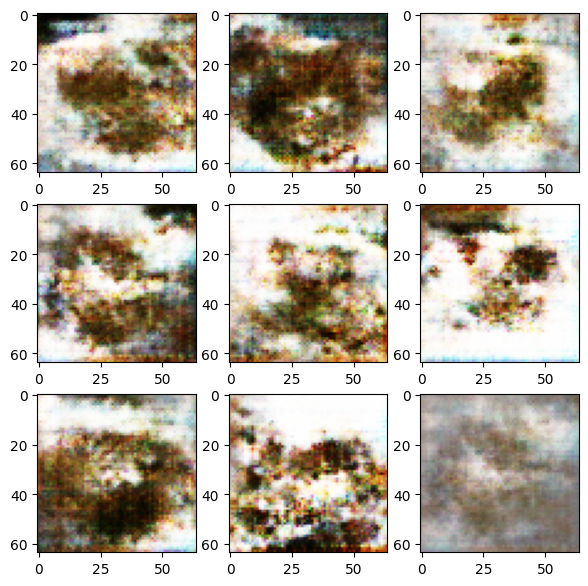

Time for epoch 1850 is 8.703847885131836 sec		disc loss: 0.706365704536438 	 gen loss: 0.680846631526947
1899 for epoch 1899 is 7.862710237503052 sec		disc loss: 0.7164195775985718 	 gen loss: 0.68780887126922613


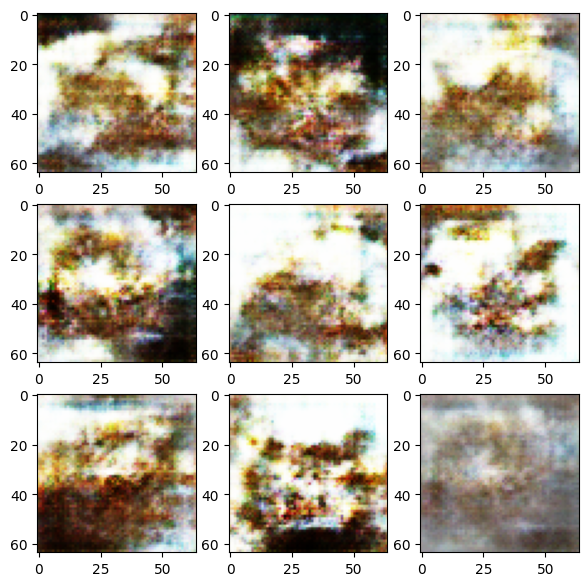

Time for epoch 1900 is 8.699362993240356 sec		disc loss: 0.6677471995353699 	 gen loss: 0.730352520942688
1949 for epoch 1949 is 7.863271236419678 sec		disc loss: 0.6947044730186462 	 gen loss: 0.67001944780349734


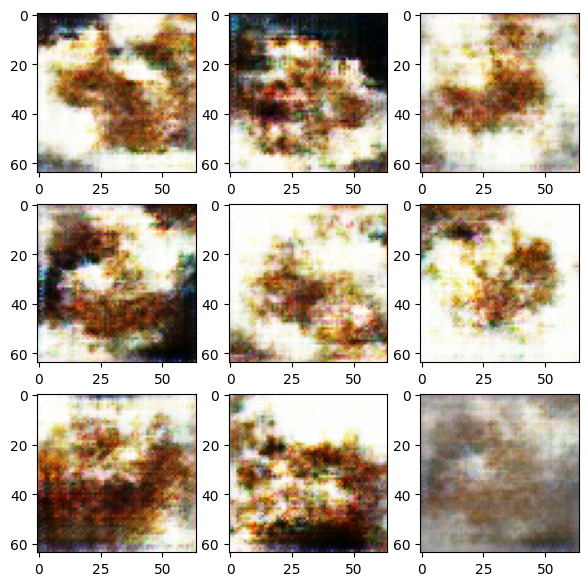

Time for epoch 1950 is 8.809884071350098 sec		disc loss: 0.6881653666496277 	 gen loss: 0.7099426984786987
1999 for epoch 1999 is 7.862722873687744 sec		disc loss: 0.6851894855499268 	 gen loss: 0.70945745706558239


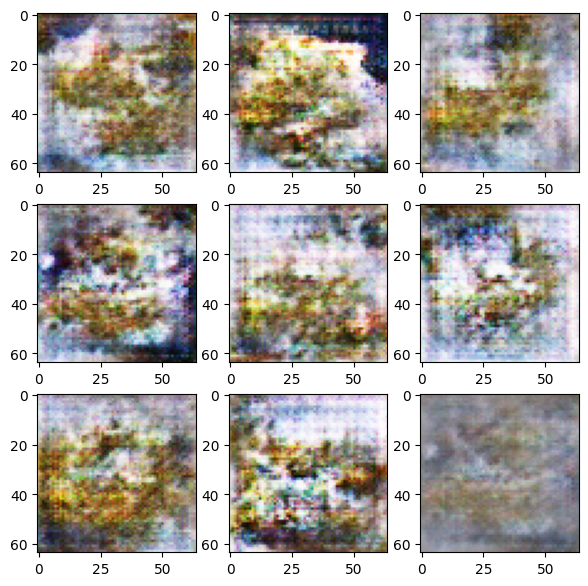

Time for epoch 2000 is 8.664951086044312 sec		disc loss: 0.7046759724617004 	 gen loss: 0.670852780342102


In [34]:
train(last_checkpoint=1800, epochs=205)


In [38]:
ds = ds.repeat(4)

In [39]:
ds = ds.map(data_augmentation)

In [ ]:
checkpoint.restore(checkpoint_prefix+'-71')
train(last_checkpoint=1800, epochs=1200)

Przez pierwsze 1600, przez warstwy augmentacji zdjęć musiałem resetować uczenie co 200 epok i trwało uczenie trochę dłużej.
Następnie przez ponad 200 epok przetestowałem czy będzie działać lepiej bez augemntacji danych i działało lepiej.
Następnie skopiowałem zbiór danych 4-krotnie i nałożyłem mapą augemntację danych i zaczęło działać lepiej, niestety augmentacja nie jest tak dobra, na kolejnym 1000 epok.  
Usunąłem trochę outputów, żeby było czytelniej.  
Niestety resety kernela związane z popsutymi warstwamy augmentacji usunęły inne outputy...

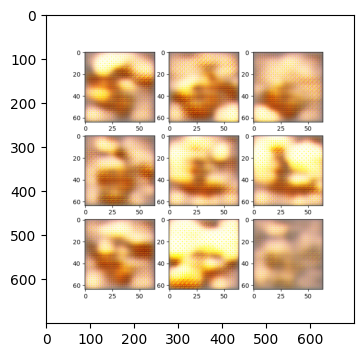

epoka: 299


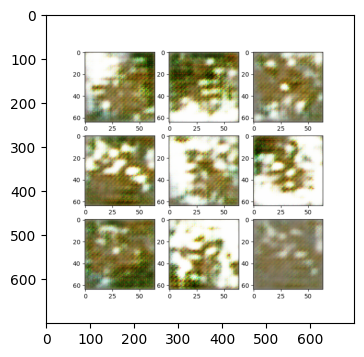

epoka: 599


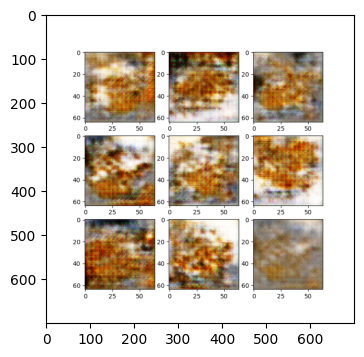

epoka: 899


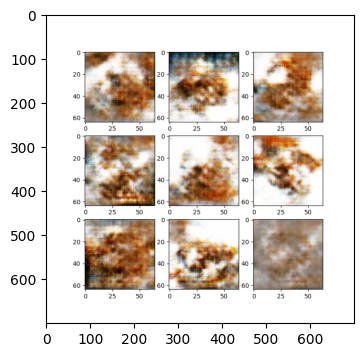

epoka: 1199


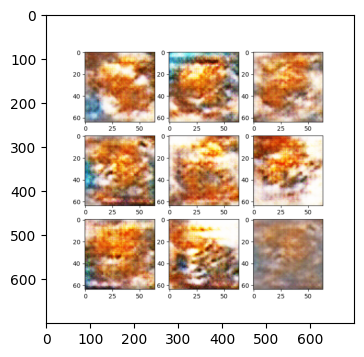

epoka: 1499


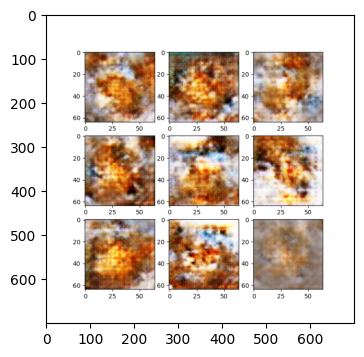

epoka: 1799


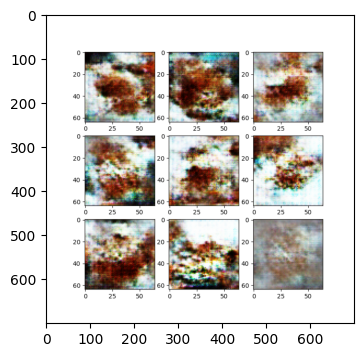

epoka: 2099


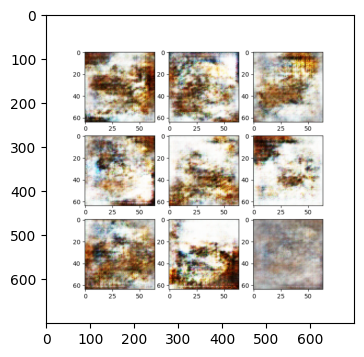

epoka: 2399


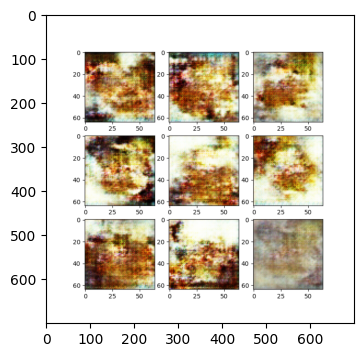

epoka: 2699


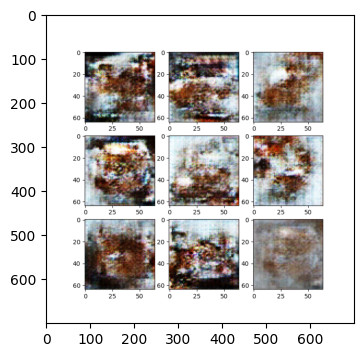

epoka: 2999


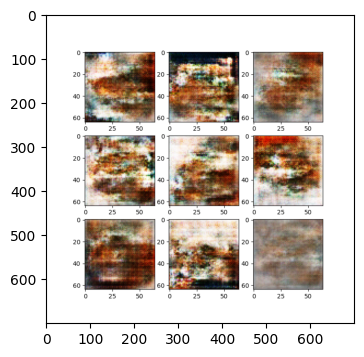

In [48]:
print_image(plt.imread('cmpimages/cmp49.png'), figsize=(4,4))
for i in range(299, 3000, 300):
    print('epoka:', i)
    print_image(plt.imread(f'cmpimages/cmp{i}.png'), figsize=(4,4))

Szczególnie na początku wartości wektorów generujących input do generator się niestety zmieniały, w związku z crashami kernela(których później udało się uniknąć).
Wyniki nie są idealne, ale wydają mi się wystarczająco dobre.  
Ewidentnie widać "szkocką kratę".

### New Generator

In [13]:
def upsampling_block(channels):
    upsamp = tf.keras.layers.UpSampling2D(size=(2,2))
    conv1 = tf.keras.layers.Conv2D(filters=channels,kernel_size=(3,3),strides=1,padding='same')
    batch_norm1 = tf.keras.layers.BatchNormalization()
    leaky_relu1 = tf.keras.layers.LeakyReLU(alpha=0.2)
    conv2 = tf.keras.layers.Conv2D(filters=channels,kernel_size=(3,3),strides=1,padding='same')
    batch_norm2 = tf.keras.layers.BatchNormalization()
    leaky_relu2 = tf.keras.layers.LeakyReLU(alpha=0.2)
    

    return [upsamp, conv1, batch_norm1, leaky_relu1, conv2, batch_norm2, leaky_relu2]


In [14]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*8*8, input_shape=(128,)),
    tf.keras.layers.Reshape((8,8,128))]+
    upsampling_block(64)+
    upsampling_block(128)+
    upsampling_block(256)+[
    tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5),strides=1,padding='same',activation='sigmoid')
])
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)       

In [15]:
tmp1 = tf.random.normal(shape=(1,128), mean=0, stddev=1)

In [16]:
tmpimg = generator.predict(tmp1)

1/1 [==============================] - 0s 161ms/step


2022-11-10 12:21:41.713385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


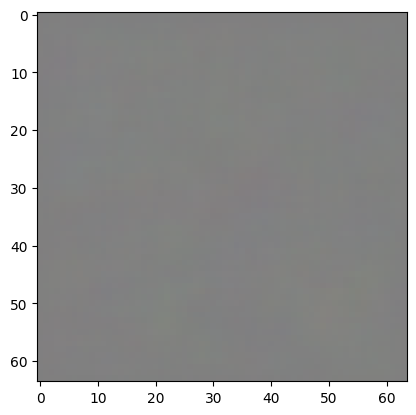

In [17]:
print_image(tmpimg[0])

In [53]:
ds = load_ds()

Found 400 files belonging to 1 classes.


Uczenie planuję zrobić analogicznie do poprzedniego.  
Pierwsze ~1600 epok policzymy z lepszą augmentacją, później ~200 bez augmentacji, później do 3000 z średnią augmentacją.  
To wymaga rekompilacji wyższych cellek.

In [29]:
checkpoint_dir = './training_checkpoints_new_gen'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# checkpoint.restore(checkpoint_prefix+'-4')

In [ ]:
train(last_checkpoint=0, epochs=205)
# train(last_checkpoint=205, epochs=205)


Niestety generator zaczął się uczyć znacznie lepiej przez co musiałem trochę popróbować różnych rzeczy by może zadziałało lepiej.  
Niestety nie udało mi się doprowadzic GANA do działania